# Introduction to Logistic Regression in PyTorch

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch 
from tqdm.notebook import tqdm

### MNIST Dataset

In [2]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

In [3]:
print("Number of MNIST training examples:{}".format(len(mnist_train)))
print("Number of MNIST test examples:{}".format(len(mnist_test)))

Number of MNIST training examples:60000
Number of MNIST test examples:10000


Pick out the 4th example from the training set

In [4]:
image, label = mnist_train[3]
print(image,label)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

Plot the image

Default image shape:torch.Size([1, 28, 28])
Reshaped image shape:torch.Size([28, 28])


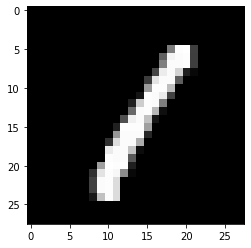

In [5]:
print("Default image shape:{}".format(image.shape))
image = image.reshape([28,28])
print("Reshaped image shape:{}".format(image.shape))
plt.imshow(image, cmap="gray")

Print the label

In [6]:
print("The label for this image: {}".format(label))

The label for this image: 1


While we could work directly with the data as a `torchvision.dataset`, we'll find it useful to use a `DataLoader`, which will take care of shuffling and batching:

In [7]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

An example of a minibatch drawn from a `DataLoader`:

In [8]:
data_train_iter = iter(train_loader)
images, labels = data_train_iter.next()

print("Shape of the minibatch of images: {}".format(images.shape))
print("Shape of the minibatch of labels: {}".format(labels.shape))

Shape of the minibatch of images: torch.Size([100, 1, 28, 28])
Shape of the minibatch of labels: torch.Size([100])


## Logistic Regression Model

### Flattening the minibatch

In [9]:
x = images.view(-1, 28*28)
print("The shape of input x: {}".format(x.shape))

The shape of input x: torch.Size([100, 784])


To get our predicted probabilities of each digit, let's first start with the probability of a digit being a 1 like the image above. 
For our simple model, we can start by applying a linear transformation. 
That is, we multiply each pixel $x_i$ of the input row vector by a weight $w_{i,1}$, sum them all together, and then add a bias $b_1$.
This is equivalent to a dot product between the class "1" weights and the input:

\begin{align}
y_1 = \sum_i x_i w_{i,1} + b_1
\end{align}

The magnitude of this result $y_1$, we'll take as being correlated to our belief in how likely we think the input digit was a 1. 
The higher the value of $y_1$, the more likely we think the input image $x$ was a 1 (i.e., we'd hope we'd get a relatively large value for $y_1$ for the above image). 
Remember though, our original goal was to identify all 10 digits, so we actually have:

\begin{align*}
y_0 =& \sum_i x_i w_{i,0} + b_0 \\
y_1 =& \sum_i x_i w_{i,1} + b_1 \\
y_2 =& \sum_i x_i w_{i,2} + b_2 \\
y_3 =& \sum_i x_i w_{i,3} + b_3 \\
y_4 =& \sum_i x_i w_{i,4} + b_4 \\
y_5 =& \sum_i x_i w_{i,5} + b_5 \\
y_6 =& \sum_i x_i w_{i,6} + b_6 \\
y_7 =& \sum_i x_i w_{i,7} + b_7 \\
y_8 =& \sum_i x_i w_{i,8} + b_8 \\
y_9 =& \sum_i x_i w_{i,9} + b_9
\end{align*}

We can express this in matrix form as:

\begin{align}
y = x W + b 
\end{align}

To take advantage of parallel computation, we commonly process multiple inputs $x$ at once, in a minibatch.
We can stack each input $x$ into a matrix $X$, giving us 

\begin{align}
Y = X W + b 
\end{align}

Visualizing the dimensions:

<img src="Figures/mnist_matmul.PNG" width="500"/>

In our specific example, the minibatch size $m$ is $100$, the dimension of the data is $28 \times 28=784$, and the number of classes $c$ is $10$.
While $X$ and $Y$ are matrices due to the batching, conventionally, they are often given lowercase variable names, as if they were for a single example.
We will use `x` and `y` throughout.

The weight $W$ and bias $b$ make up the parameters of this model.
When we say that we want to "learn the model," what we're really trying to do is find good values for every element in $W$ and $b$.
Before we begin learning, we need to initialize our parameters to some value, as a starting point.
Here, we don't really know what the best values are, so we going to initialize $W$ randomly (using something called [Xavier initialization](http://proceedings.mlr.press/v9/glorot10a.html)), and set $b$ to a vector of zeros.

In [10]:
# Randomly initialize weights W
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()

# Initialize bias b as 0s
b = torch.zeros(10, requires_grad=True)

根本没有看懂上面一cell的码

As both `W` and `b` are parameters we wish to learn, we set `requires_grad` to `True`. 
This tells PyTorch's autograd to track the gradients for these two variables, and all the variables depending on `W` and `b`.

With these model parameters, we compute $y$:

In [11]:
# Linear transformation with W and b
y = torch.matmul(x, W) + b

In [12]:
print(y[0,:])

tensor([-0.4164,  0.0575, -1.2267, -0.2569, -0.4148,  0.2220, -0.2324,  0.1274,
        -0.3803,  0.0615], grad_fn=<SliceBackward>)


In [13]:
# Option 1: Softmax to probabilities from equation
py_eq = torch.exp(y) / torch.sum(torch.exp(y), dim=1, keepdim=True)
print("py[0] from equation: {}".format(py_eq[0]))

# Option 2: Softmax to probabilities with torch.nn.functional
import torch.nn.functional as F
py = F.softmax(y, dim=1)
print("py[0] with torch.nn.functional.softmax: {}".format(py[0]))

py[0] from equation: tensor([0.0788, 0.1265, 0.0350, 0.0924, 0.0789, 0.1492, 0.0947, 0.1357, 0.0817,
        0.1271], grad_fn=<SelectBackward>)
py[0] with torch.nn.functional.softmax: tensor([0.0788, 0.1265, 0.0350, 0.0924, 0.0789, 0.1492, 0.0947, 0.1357, 0.0817,
        0.1271], grad_fn=<SelectBackward>)


We've now defined the forward pass of our model: given an input image, the graph returns the probabilities the model thinks the input is each of the 10 classes. Are we done?

In [14]:
print(labels.shape)

torch.Size([100])


打印supervised learning中正确的y

In [15]:
# Cross-entropy loss from equation
cross_entropy_eq = torch.mean(-torch.log(py_eq)[range(labels.shape[0]), labels])
print("cross entropy from equation: {}".format(cross_entropy_eq))

# Option 2: cross-entropy loss with torch.nn.functional
cross_entropy = F.cross_entropy(y, labels)
print("cross entropy with torch.nn.functional.cross_entropy: {}".format(cross_entropy))

cross entropy from equation: 2.342071294784546
cross entropy with torch.nn.functional.cross_entropy: 2.342071294784546


Note that PyTorch's cross-entropy loss combines the softmax operator and cross-entropy into a single operation, for numerical stability reasons.
Don't do the softmax twice!
Make sure to feed in the pre-softmax logits `y`, not the post-softmax probabilities `py`.

## Minimize the loss

#### The backwards pass

Now that we have the loss as a way of quantifying how badly the model is doing, we can improve our model by changing the parameters in a way that minimizes the loss.
For neural networks, the common way of doing this is with backpropagation: we take the gradient of the loss with respect to $W$ and $b$ and take a step in the direction that reduces our loss.

If we were not using a deep learning framework like PyTorch, we would have to go through and derive all the gradients ourselves by hand, then code them into our program. 
We certainly still could.
However, with modern auto-differentiation libraries, it's much faster and easier to let the computer do it.

First, we need to create an optimizer.
There are many choices, but since logistic regression is fairly simple, we'll use standard stochastic gradient descent (SGD), which makes the following update:

\begin{align}
\theta_{t+1} = \theta_t - \alpha \nabla_\theta \mathcal{L}
\end{align}

where $\theta$ is a parameter, $\alpha$ is our learning rate (step size), and $\nabla_\theta \mathcal{L}$ is the gradient of our loss with respect to $\theta$.

In [16]:
# Optimizer
optimizer = torch.optim.SGD([W,b], lr=0.1)

When we created our parameters $W$ and $b$, we indicated that they require gradients.
To compute the gradients for $W$ and $b$, we call the `backward()` function on the cross-entropy loss.

In [19]:
cross_entropy.backward()

Each of the variables that required gradients have now accumulated gradients.
We can see these for example on `b`:

In [20]:
b.grad

tensor([ 0.0041,  0.0051, -0.0393, -0.0060, -0.0340,  0.0581, -0.0052,  0.0235,
        -0.0116,  0.0052])

perform update

In [21]:
optimizer.step()

In [22]:
b

tensor([-0.0004, -0.0005,  0.0039,  0.0006,  0.0034, -0.0058,  0.0005, -0.0024,
         0.0012, -0.0005], requires_grad=True)

We set our learning rate to 0.1, so `b` has been updated by `-0.1*b.grad`:

In [23]:
print("b.grad before zero_grad(): {}".format(b.grad))
optimizer.zero_grad()
print("b.grad after zero_grad: {}".format(b.grad))

b.grad before zero_grad(): tensor([ 0.0041,  0.0051, -0.0393, -0.0060, -0.0340,  0.0581, -0.0052,  0.0235,
        -0.0116,  0.0052])
b.grad after zero_grad: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


## Model Training

In [24]:
# Iterate through train set minibatchs
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

  0%|          | 0/600 [00:00<?, ?it/s]

## Model Test

In [26]:
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs
    for images, labels in tqdm(test_loader):
        #Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
        
print("Test accuracy: {}".format(correct/total))

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9036999940872192


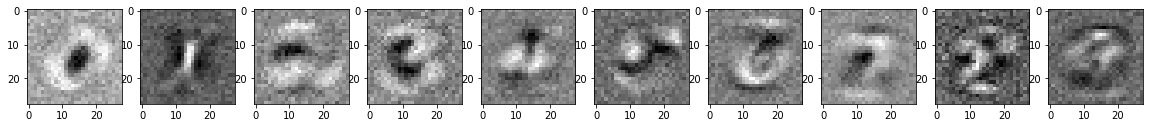

In [27]:
# Get weights
fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for digit in range(10):
    ax[digit].imshow(W[:,digit].detach().view(28, 28), cmap='gray')

## The Full Code

In [28]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Initialize parameters
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()
b = torch.zeros(10, requires_grad=True)

# Optimizer
optimizer = torch.optim.SGD([W,b], lr=0.1)

# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9025999903678894


In [30]:
class xW_plus_b:
    def __init__(self, dim_in, dim_out):
        self.W = torch.randn(dim_in, dim_out)/np.sqrt(dim_in)
        self.W.requires_grad_()
        self.b = torch.zeros(dim_out, requires_grad = True)
        
    def forward(self, x):
        return torch.matmul(x, self.W) + self.b

In [31]:
lin_custom = xW_plus_b(784, 10)
print("W: {}".format(lin_custom.W.shape))
print("b: {}".format(lin_custom.b.shape))

W: torch.Size([784, 10])
b: torch.Size([10])


In [32]:
x_rand = torch.randn(1, 784)
y = lin_custom.forward(x_rand)
print(y.shape)

torch.Size([1, 10])


In [33]:
import torch.nn as nn

In [34]:
lin = nn.Linear(784, 10)
print("Linear parameters: {}".format([p.shape for p in lin.parameters()]))

y = lin(x_rand)
print(y.shape)

Linear parameters: [torch.Size([10, 784]), torch.Size([10])]
torch.Size([1, 10])


In [38]:
class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784,10)
        
    def forward(self, x):
        return self.lin(x)

In [39]:
model = MNIST_Logistic_Regression()
y = model(x_rand)
print("The model: \n{}".format(model))
print("\nParameters: \n{}".format(list(model.parameters())))
print("\nOutput shape: \n{}".format(y.shape))

The model: 
MNIST_Logistic_Regression(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

Parameters: 
[Parameter containing:
tensor([[-0.0130, -0.0285, -0.0193,  ...,  0.0022,  0.0210,  0.0129],
        [ 0.0338,  0.0029,  0.0318,  ..., -0.0054, -0.0239, -0.0297],
        [-0.0149, -0.0328, -0.0045,  ...,  0.0141,  0.0247, -0.0131],
        ...,
        [ 0.0353, -0.0249, -0.0297,  ...,  0.0318, -0.0120, -0.0284],
        [-0.0196, -0.0243,  0.0170,  ..., -0.0356, -0.0344, -0.0048],
        [ 0.0069,  0.0272,  0.0344,  ..., -0.0184,  0.0240,  0.0170]],
       requires_grad=True), Parameter containing:
tensor([ 0.0259,  0.0229,  0.0016, -0.0122, -0.0292, -0.0262,  0.0057,  0.0090,
         0.0229,  0.0097], requires_grad=True)]

Output shape: 
torch.Size([1, 10])


## The Full Code

In [40]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, x):
        return self.lin(x)

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Instantiate model
model = MNIST_Logistic_Regression()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = criterion(y, labels)
    # Backward pass
    loss.backward()
    optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = model(x)
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9017000198364258
